In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [62]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [63]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
df.isnull().sum().sum()

0

In [65]:
data = np.array(df)
m, n = data.shape
print(m, n)
np.random.shuffle(data)

42000 785


In [66]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

data_train = data[1000:m].T

Y_train = data_train[0] 
X_train = data_train[1:n] 

X_train = X_train / 255.0
X_dev = X_dev / 255.0

In [67]:
print(X_dev.shape)

(784, 1000)


In [68]:
def init_parameters():
    W1 = np.random.randn(64, 784) * np.sqrt(2 / 784) 
    b1 = np.zeros((64, 1))
    W2 = np.random.randn(64, 64) * np.sqrt(2 / 64) 
    b2 = np.zeros((64, 1)) 
    W3 = np.random.randn(10, 64) * np.sqrt(2 / 64) 
    b3 = np.zeros((10, 1)) 
    return W1, b1, W2, b2, W3, b3

def ReLU(z):
    return np.maximum(z, 0)
    # return np.where(z > 0, z, 0.1 * z)

def Leaky_ReLU(z):
    # return np.maximum(z, 0)
    return np.where(z > 0, z, 0.4 * z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def deriv_sigmoid(z):
    s = sigmoid(z)
    return s * (1 - s)

def softmax(z):
    exp_shifted = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=0, keepdims=True)

def deriv_ReLU(z):
    return (z>0)
    # return np.where(z>0, 1, 0.1)

def deriv_Leaky_ReLU(z):
    # return (z>0)
    return np.where(z>0, 1, 0.4)
    
def forward_prop(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = Leaky_ReLU(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    
    return Z1, Z2, Z3, A1, A2, A3
    

def one_hot(Y):
    one_hot_Y = np.zeros((Y.max() + 1, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    # one_hot_Y = one_hot_Y.T
    return one_hot_Y

def back_prop(Z1, A1, Z2, A2, Z3, A3, W3, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = Y.size
    dZ3 = (A3 - one_hot_Y)
    dw3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dZ2 = np.dot(W3.T, dZ3) * deriv_Leaky_ReLU(Z2)
    dw2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * deriv_ReLU(Z1)
    dw1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    return dw1, db1, dw2, db2, dw3, db3


def update_param(W1, W2, W3, b1, b2, b3, dw1, dw2, dw3, db1, db2, db3, alpha):
    W1 = W1 - (alpha * dw1)
    W2 = W2 - (alpha * dw2)
    W3 = W3 - (alpha* dw3)
    b1 = b1 - (alpha * db1)
    b2 = b2 - (alpha * db2)
    b3 = b3 - (alpha * db3)
    return W1, b1, W2, b2, W3, b3

def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.mean(predictions == Y)
    

In [69]:
def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2, W3, b3 = init_parameters()
    # Y = one_hot_Y(Y)
    for i in range(0, iterations):
        Z1, Z2, Z3, A1, A2, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        dw1, db1, dw2, db2, dw3, db3 = back_prop(Z1, A1, Z2, A2, Z3, A3, W3, W2, X, Y)
        W1, b1, W2, b2, W3, b3 = update_param(W1, W2, W3, b1, b2, b3, dw1, dw2, dw3, db1, db2, db3, alpha)
        
        if i%10 == 0:
            print("iterations : ", i)
            accuracy = get_accuracy(get_predictions(A3), Y)
            print("Accuracy : ", accuracy)

    
    predictions = get_predictions(A3)
    accuracy = get_accuracy(predictions, Y)
    print("Z1 : ", np.max(Z1), " Z2 : ", np.max(Z2), "Z3 : ", np.max(Z3))
    print("Final Accuracy after ", i, "iterations : ", accuracy)
    return W1, b1, W2, b2, W3, b3

In [70]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 1000, 0.1)

iterations :  0
Accuracy :  0.08482926829268293
iterations :  10
Accuracy :  0.6091463414634146
iterations :  20
Accuracy :  0.7706585365853659
iterations :  30
Accuracy :  0.8234634146341463
iterations :  40
Accuracy :  0.848390243902439
iterations :  50
Accuracy :  0.8618780487804878
iterations :  60
Accuracy :  0.8711463414634146
iterations :  70
Accuracy :  0.8778536585365854
iterations :  80
Accuracy :  0.8831951219512195
iterations :  90
Accuracy :  0.8883414634146342
iterations :  100
Accuracy :  0.8920243902439025
iterations :  110
Accuracy :  0.8948536585365854
iterations :  120
Accuracy :  0.8982926829268293
iterations :  130
Accuracy :  0.9009756097560976
iterations :  140
Accuracy :  0.9029756097560976
iterations :  150
Accuracy :  0.9048048780487805
iterations :  160
Accuracy :  0.9065365853658537
iterations :  170
Accuracy :  0.9082439024390244
iterations :  180
Accuracy :  0.9099024390243903
iterations :  190
Accuracy :  0.9113170731707317
iterations :  200
Accuracy :  0

In [71]:
def make_predictions(X, Y, W1, b1, W2, b2, W3, b3):
    Z1, Z2, Z3, A1, A2, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3) 
    predictions = get_predictions(A3)
    accuracy = get_accuracy(predictions, Y)
    print("The dev data accuracy is : " ,accuracy)
    return predictions

In [78]:
dev_predictions = make_predictions(X_dev, Y_dev, W1, b1, W2, b2, W3, b3)

The dev data accuracy is :  0.962


In [79]:
def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    label = Y_train[index]
    
    # Forward propagation
    Z1, Z2, Z3, A1, A2, A3 = forward_prop(current_image, W1, b1, W2, b2, W3, b3)
    prediction = get_predictions(A3)[0]

    print("Prediction: ", prediction)
    print("Label: ", label)

    # Reshape and display the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


Prediction:  4
Label:  4


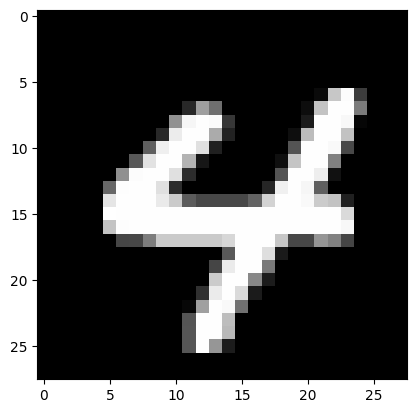

Prediction:  9
Label:  9


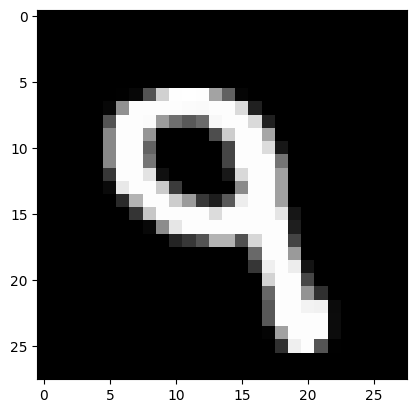

Prediction:  8
Label:  8


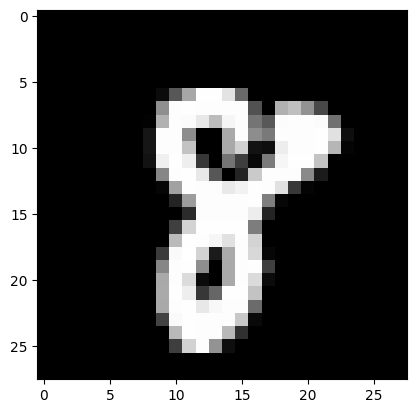

Prediction:  8
Label:  8


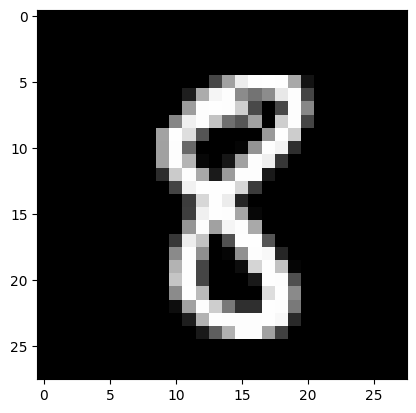

Prediction:  2
Label:  2


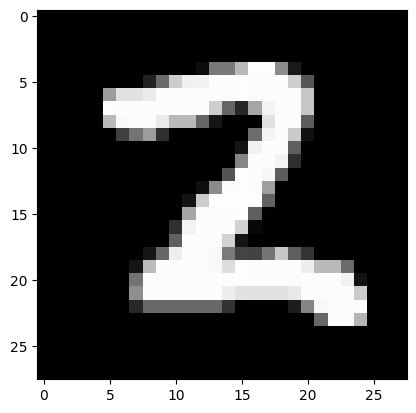

Prediction:  1
Label:  1


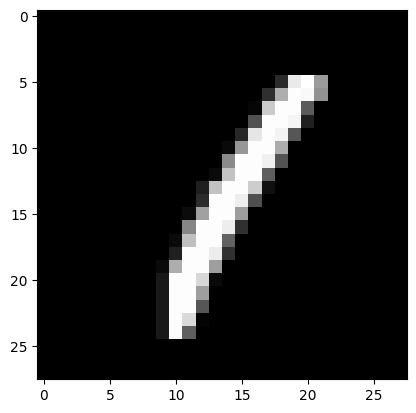

Prediction:  2
Label:  2


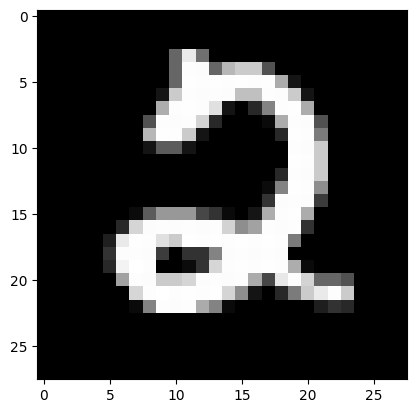

Prediction:  2
Label:  7


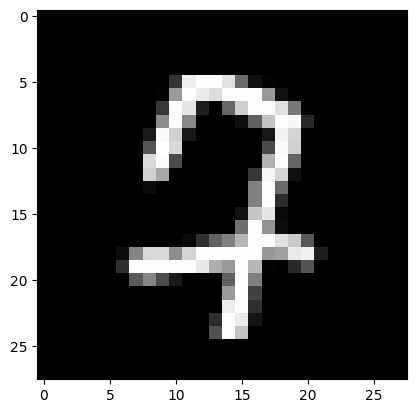

Prediction:  1
Label:  1


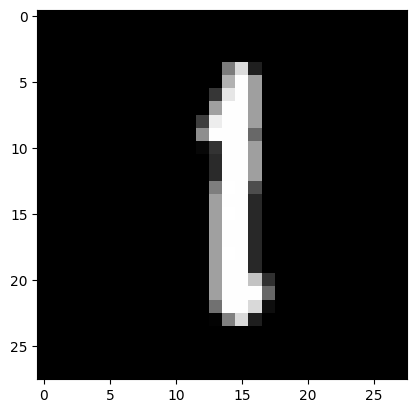

Prediction:  5
Label:  5


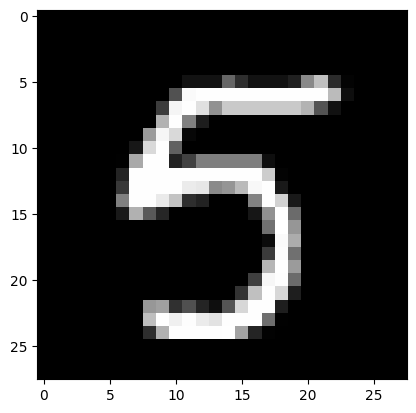

Prediction:  7
Label:  7


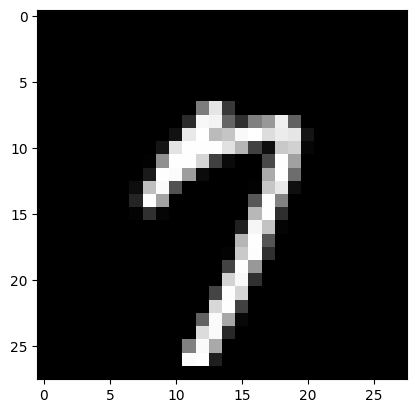

In [76]:
for i in range(11):
    test_prediction(i, W1, b1, W2, b2, W3, b3)
# test_prediction(0, W1, b1, W2, b2, W3, b3)
# test_prediction(1, W1, b1, W2, b2, W3, b3)
# test_prediction(2, W1, b1, W2, b2, W3, b3)
# test_prediction(3, W1, b1, W2, b2, W3, b3)